In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace = True)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.rename(columns={'v1':'target','v2':'text'},inplace = True)
df.sample(5)

,target,text
3324,ham,Nope... Juz off from work...
1148,ham,I'm not driving... Raining! Then i'll get caug...
5266,ham,HI DARLIN ITS KATE ARE U UP FOR DOIN SOMETHIN ...
2623,ham,I'm coming home 4 dinner.
1138,ham,What * u wearing?


In [9]:
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [11]:
df.duplicated().sum()

403

In [12]:
df = df.drop_duplicates(keep='first')
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

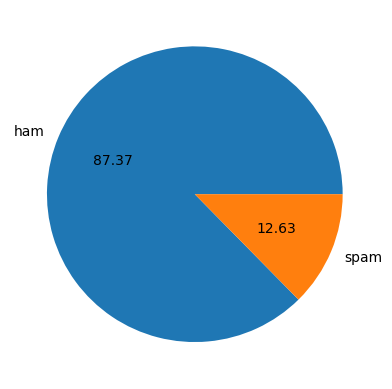

In [13]:
plt.pie(df['target'].value_counts(),labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [14]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ohale\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ohale\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [15]:
df['num_of_character'] = df['text'].apply(len)
df['num_word'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentence'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df[['num_of_character','num_word','num_sentence']].describe()

,num_of_character,num_word,num_sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [16]:
df[df['target'] == 0][['num_of_character','num_word','num_sentence']].describe()

,num_of_character,num_word,num_sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [17]:
df[df['target'] == 1][['num_of_character','num_word','num_sentence']].describe() 

,num_of_character,num_word,num_sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


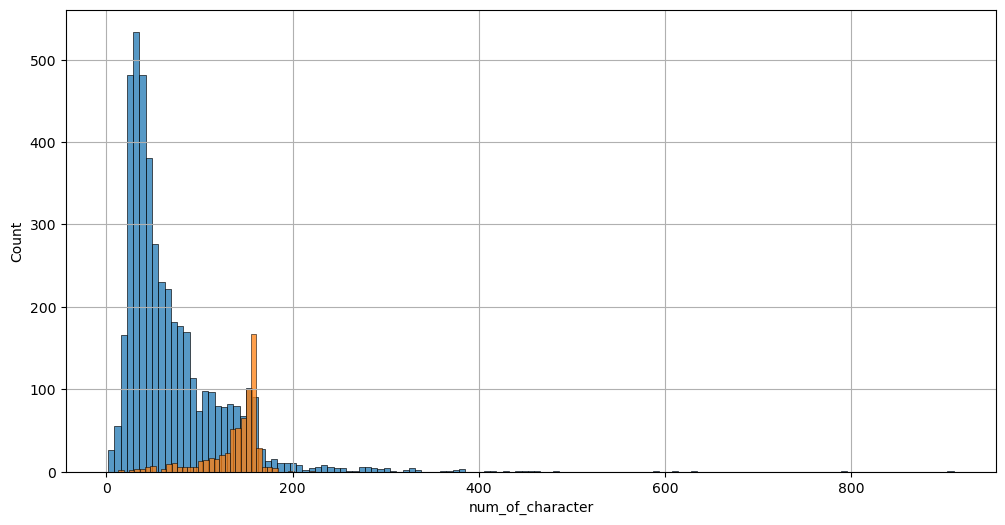

In [18]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_of_character'])
sns.histplot(df[df['target'] == 1]['num_of_character'])
plt.grid()

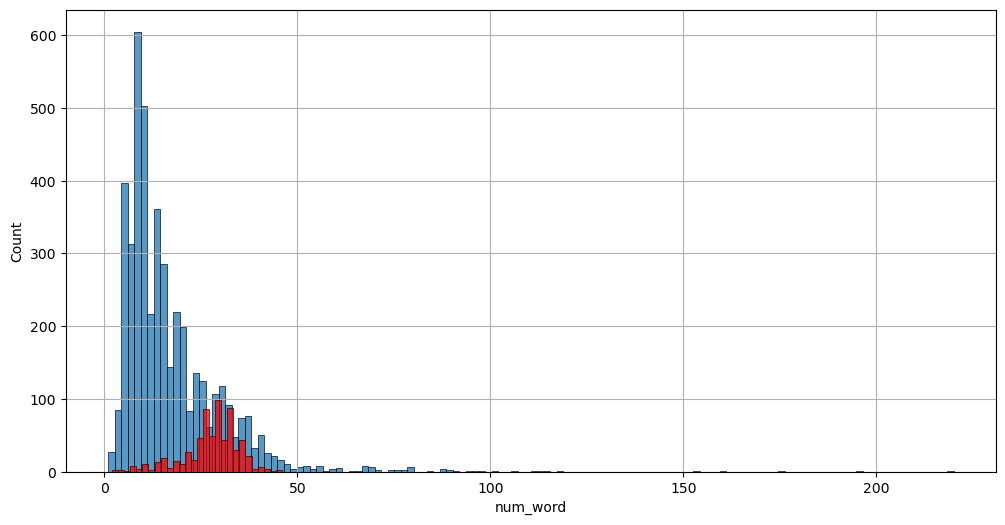

In [19]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_word'])
sns.histplot(df[df['target'] == 1]['num_word'],color='red')
plt.grid()

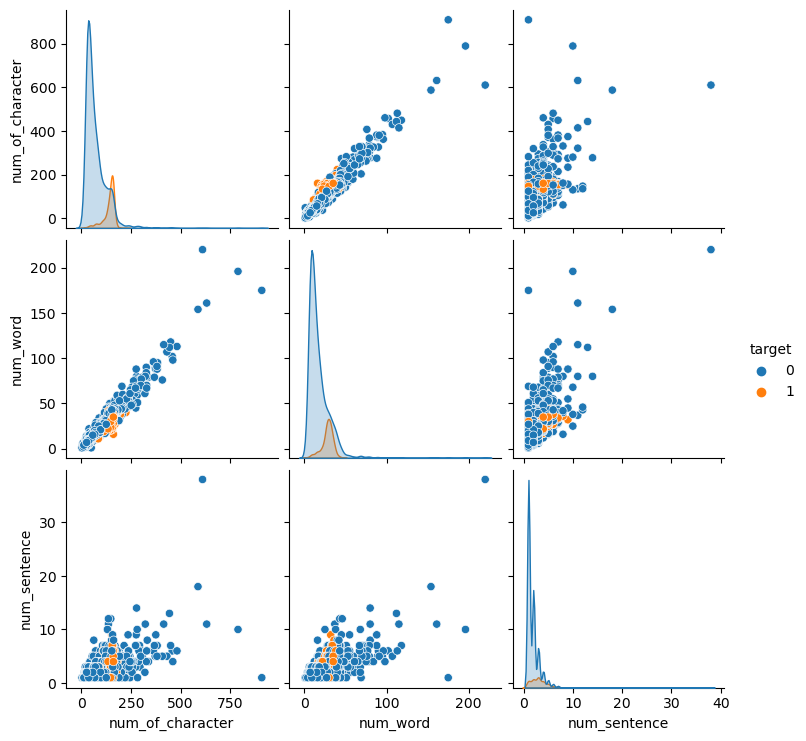

In [20]:
sns.pairplot(df,hue='target')
plt.grid()

<Axes: >

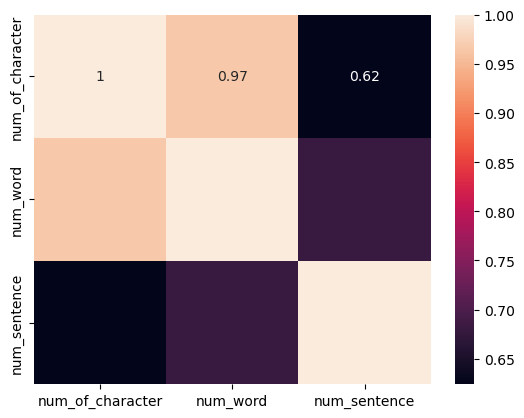

In [29]:
sns.heatmap(df[['num_of_character','num_word','num_sentence']].corr(),annot=True)

In [30]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear()
    ps = PorterStemmer()
    for i in text:
        y.append(ps.stem(i))
        return " ".join(y)


In [31]:
df['text'][10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [32]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon'

In [33]:
df['transformed_text'] = df['text'].apply(transform_text)
df.head(5)

,target,text,num_of_character,num_word,num_sentence,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go
1,0,Ok lar... Joking wif u oni...,29,8,2,ok
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free
3,0,U dun say so early hor... U c already then say...,49,13,1,u
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah


In [35]:
!pip install wordcloud


   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   ------- ------------------------------- 61.4/300.2 kB 812.7 kB/s eta 0:00:01
   --------------------- ------------------ 163.8/300.2 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------  297.0/300.2 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 1.7 MB/s eta 0:00:00


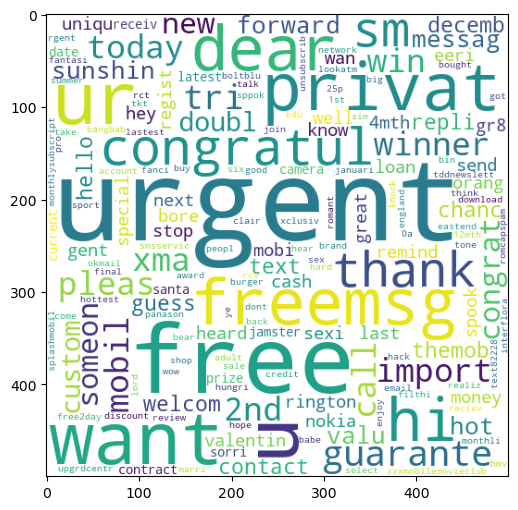

In [36]:
from wordcloud import WordCloud  # Import WordCloud class from the wordcloud library

# Your existing code
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)


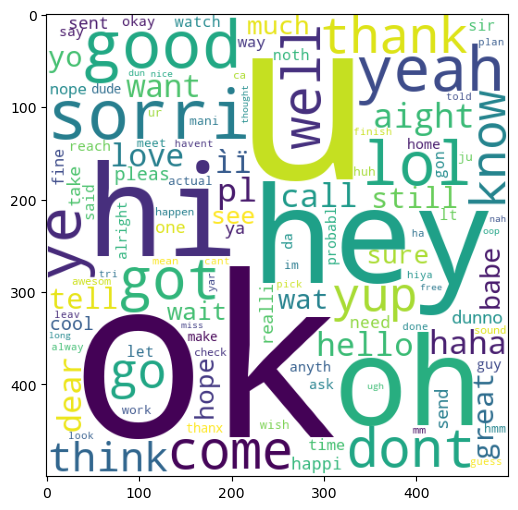

In [37]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [39]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features = 4000)

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer

# Replace missing values with an empty string
df['transformed_text'].fillna('', inplace=True)

# Initialize TfidfVectorizer
tfidf = TfidfVectorizer()

# Fit-transform the text data
x = tfidf.fit_transform(df['transformed_text']).toarray()


In [42]:
x.shape

(5169, 1376)

In [43]:
y = df['target'].values

In [44]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state = 20)

In [45]:
gnb = GaussianNB()
mnb = MultinomialNB(alpha=1.0)
bnb = BernoulliNB()
lg = LogisticRegression()
svm = SVC()

In [46]:
gnb.fit(x_train,y_train)
y_pred1 = gnb.predict(x_test)
print(accuracy_score(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.5812379110251451
0.23861566484517305


In [47]:
mnb.fit(x_train,y_train)
y_pred2 = mnb.predict(x_test)
print(accuracy_score(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.8907156673114119
0.9230769230769231


In [48]:
bnb.fit(x_train,y_train)
y_pred3 = bnb.predict(x_test)
print(accuracy_score(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.8694390715667312
1.0


In [49]:
lg.fit(x_train,y_train)
y_pred4 = lg.predict(x_test)
print(accuracy_score(y_test,y_pred4))
print(precision_score(y_test,y_pred4))

0.8858800773694391
0.85


In [50]:
svm.fit(x_train,y_train)
y_pred5 = svm.predict(x_test)
print(accuracy_score(y_test,y_pred5))
print(precision_score(y_test,y_pred5))

0.9052224371373307
0.8636363636363636


In [51]:
pickle.dump(tfidf,open('nlp_vectorizer1.pkl','wb'))
pickle.dump(mnb,open('nlp_model1.pkl','wb'))

In [52]:
pred = bnb.predict(x_test)
pred

array([0, 0, 0, ..., 0, 0, 0])

In [53]:
y_test

array([0, 0, 1, ..., 0, 0, 0])

In [54]:
x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])